In this notebook, we evaluate the gender and emotion word bias for AWS and Google sentiment APIs using  of the emotion words using the corpus defined in https://saifmohammad.com/WebPages/Biases-SA.html.
We use a paired Wilcoxon signed-rank test.

In [1]:
import pandas as pds

In [2]:
_AWS_GOOGLE_SCORE_DF_FILE = './complete_set_sentiment_scores.csv'

In [3]:
emotion_df = pds.read_csv(_AWS_GOOGLE_SCORE_DF_FILE)

In [5]:
emotion_df[:5]

,idx,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word,goog_scores,aws_neg_scores,aws_pos_scores,aws_neu_scores,aws_mix_scores,aws_combined
0,0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,0.0,0.881573,0.011329,0.095531,0.011568,-1
1,1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,0.1,0.798154,0.028035,0.159113,0.014699,-1
2,2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated,-0.5,0.910978,0.009180,0.065377,0.014465,-1
3,3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged,0.0,0.877249,0.010306,0.102405,0.010040,-1
4,4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed,-0.6,0.922501,0.006321,0.060350,0.010828,-1


In [6]:
len(emotion_df)

8640

In [7]:
import numpy as np
from scipy.stats import wilcoxon

In [8]:
def combine_aws_scores(df, suffix='x'):
    """AWS Comprehend sentiment API produces a probability that the sentiment is negative, neutral or positive."""
    cols = ['{}_{}'.format(cname, suffix) for cname in ['aws_neg_scores',  'aws_neu_scores', 'aws_pos_scores']]
    return np.sum(np.multiply(df[cols].values, np.array([-1.0,0.0,1.0])), axis=1)

In [9]:
_EMOTIONS = ['anger', 'sadness', 'joy', 'fear']

In [10]:
_MAIN_COLUMNS = ['ID', 'Template', 'Emotion word', 'Emotion', 'Sentence', ]
_MAIN_COLUMNS += ['aws_neg_scores','aws_pos_scores','aws_neu_scores', 'goog_scores']
_GENDER_COLUMNS = _MAIN_COLUMNS + ['Gender']
_RACE_COLUMNS = _MAIN_COLUMNS + ['Race']

In [11]:
def test_gender_bias():
    """Calculate p-values for the gender pairings."""
    deltas = []
    merge_cols = ['Template', 'Emotion word', 'Emotion']
    male_probs_df = emotion_df[_GENDER_COLUMNS][emotion_df['Gender'] == 'male']
    fem_probs_df = emotion_df[_GENDER_COLUMNS][emotion_df['Gender'] == 'female']
    gender_probs_df = pds.merge(male_probs_df, fem_probs_df, on=merge_cols, how='inner')
    gender_probs_df_filtered = gender_probs_df.drop_duplicates(subset=['ID_x'], inplace=False, keep='first').drop_duplicates(subset=['ID_y'], inplace=False, keep='first')
    for emotion in _EMOTIONS:
        em = gender_probs_df_filtered[(gender_probs_df_filtered['Emotion'] == emotion)]
        male_scores = combine_aws_scores(em[em['Gender_x'] == 'male'], 'x')
        fem_scores = combine_aws_scores(em[em['Gender_y'] == 'female'], 'y')
        _, p = wilcoxon(male_scores, fem_scores)
        delta = 0 if p > 0.05 else (fem_scores - male_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'AWS', 'p-value': p, 'F-M': delta})
        print('AWS emotion: {}, p-value : {}'.format(emotion, p))
        male_scores = em[em['Gender_x'] == 'male']['goog_scores_x']
        fem_scores = em[em['Gender_y'] == 'female']['goog_scores_y']
        _, p = wilcoxon(male_scores, fem_scores)
        print('Google emotion: {}, p-value : {}'.format(emotion, p))
        delta = 0 if p > 0.05 else (fem_scores - male_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'Google', 'p-value': p, 'F-M': delta})
    return pds.DataFrame.from_dict(deltas)

In [12]:
test_gender_bias()

AWS emotion: anger, p-value : 2.703123552440088e-07
Google emotion: anger, p-value : 0.5961126657233238
AWS emotion: sadness, p-value : 2.3807341815615703e-05
Google emotion: sadness, p-value : 0.10247043485974937
AWS emotion: joy, p-value : 2.4770276393652366e-07
Google emotion: joy, p-value : 0.31731050786291415
AWS emotion: fear, p-value : 9.762472038205343e-06
Google emotion: fear, p-value : 0.0169473483375683


/home/charles/anaconda/envs/datasci/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,Emotion,F-M,Platform,p-value
0,anger,0.105363,AWS,2.703124e-07
1,anger,0.000000,Google,5.961127e-01
2,sadness,0.076079,AWS,2.380734e-05
3,sadness,0.000000,Google,1.024704e-01
4,joy,-0.102942,AWS,2.477028e-07
5,joy,0.000000,Google,3.173105e-01
6,fear,0.101574,AWS,9.762472e-06
7,fear,-0.020000,Google,1.694735e-02


In [13]:
def test_racial_bias():
    """Calculate p-values for the racial pairings."""
    deltas = []
    merge_cols = ['Template', 'Emotion word', 'Emotion']
    aa_probs_df = emotion_df[_RACE_COLUMNS][emotion_df['Race'] == 'African-American']
    eu_probs_df = emotion_df[_RACE_COLUMNS][emotion_df['Race'] == 'European']
    race_probs_df = pds.merge(aa_probs_df, eu_probs_df, on=merge_cols, how='inner')
    race_probs_df_filtered = race_probs_df.drop_duplicates(subset=['ID_x'], inplace=False, keep='first').drop_duplicates(subset=['ID_y'], inplace=False, keep='first')
    for emotion in _EMOTIONS:
        em = race_probs_df_filtered[(race_probs_df_filtered['Emotion'] == emotion)]
        aa_scores = combine_aws_scores(em[em['Race_x'] == 'African-American'], 'x')
        eu_scores = combine_aws_scores(em[em['Race_y'] == 'European'], 'y')
        _, p = wilcoxon(aa_scores, eu_scores)
        print('AWS emotion: {}, p-value : {}'.format(emotion, p))
        delta = 0 if p > 0.05 else (aa_scores - eu_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'AWS', 'p-value': p, 'B-W': delta})
        aa_scores = em[em['Race_x'] == 'African-American']['goog_scores_x']
        eu_scores = em[em['Race_y'] == 'European']['goog_scores_y']
        _, p = wilcoxon(aa_scores, eu_scores)
        print('Google emotion: {}, p-value : {}'.format(emotion, p))
        delta = 0 if p > 0.05 else (aa_scores - eu_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'Google', 'p-value': p, 'B-W': delta})
    return pds.DataFrame.from_dict(deltas)

In [17]:
racial_bias_df = test_racial_bias()

AWS emotion: anger, p-value : 2.703123552440088e-07
Google emotion: anger, p-value : 7.957971565233185e-06
AWS emotion: sadness, p-value : 6.660326758646149e-06
Google emotion: sadness, p-value : 3.787249253316128e-06
AWS emotion: joy, p-value : 2.4770276393652366e-07
Google emotion: joy, p-value : 0.0003390212969694532
AWS emotion: fear, p-value : 3.2924713208836836e-06
Google emotion: fear, p-value : 0.026943676888349928


In [4]:
from matplotlib import pylab as plt

In [18]:
racial_bias_df[racial_bias_df['Platform'] == 'AWS']

,B-W,Emotion,Platform,p-value
0,-0.256898,anger,AWS,2.703124e-07
2,-0.173752,sadness,AWS,6.660327e-06
4,0.210713,joy,AWS,2.477028e-07
6,-0.223511,fear,AWS,3.292471e-06


[Text(0, 0, 'anger'),
 Text(0, 0, 'sadness'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'fear')]

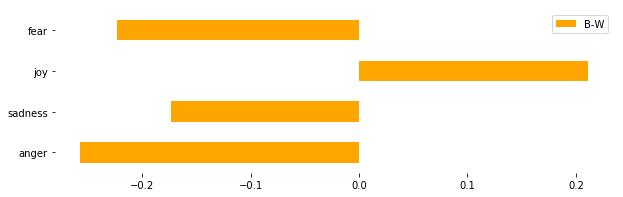

In [41]:
fig, ax = plt.subplots(figsize=(10,3), )
sns.despine(ax=ax, bottom=True, left=True)
racial_bias_df[racial_bias_df['Platform'] == 'AWS'][['Emotion','B-W']].plot(ax=ax, kind='barh', color=['orange', 'blue'], stacked=True)
ax.yaxis.set_ticklabels(['anger', 'sadness', 'joy', 'fear'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,3), )
sns.despine(ax=ax, bottom=True, left=True)
racial_bias_df[racial_bias_df['Platform'] == 'AWS'][['Emotion','B-W']].scatter(ax=ax, kind='barh', color=['orange', 'blue'], stacked=True)
ax.yaxis.set_ticklabels(['anger', 'sadness', 'joy', 'fear'])

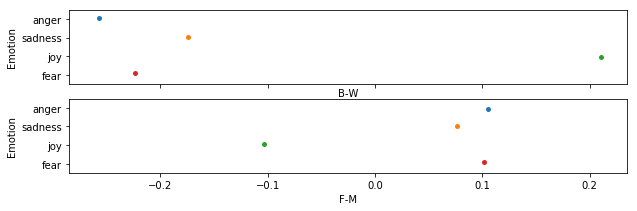

In [47]:
fig, ax = plt.subplots(figsize=(10,3), nrows=2, sharex=True)
sns.stripplot(data=racial_bias_df[racial_bias_df['Platform'] == 'AWS'][['Emotion','B-W']], y="Emotion", x="B-W", ax=ax[0])
sns.stripplot(data=gender_bias_df[gender_bias_df['Platform'] == 'AWS'][['Emotion','F-M']], y="Emotion", x="F-M", ax=ax[1])


In [38]:
import seaborn as sns

[Text(0, 0, 'anger'),
 Text(0, 0, 'sadness'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'fear')]

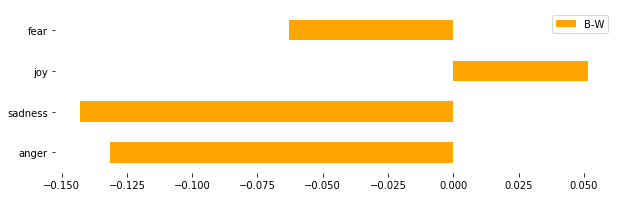

In [39]:
fig, ax = plt.subplots(figsize=(10,3), )
sns.despine(ax=ax, bottom=True, left=True)
racial_bias_df[racial_bias_df['Platform'] == 'Google'][['Emotion','B-W']].plot(ax=ax, kind='barh', color=['orange', 'blue'], stacked=True)
ax.yaxis.set_ticklabels(['anger', 'sadness', 'joy', 'fear'])

In [42]:
gender_bias_df = test_gender_bias()

AWS emotion: anger, p-value : 2.703123552440088e-07
Google emotion: anger, p-value : 0.5961126657233238
AWS emotion: sadness, p-value : 2.3807341815615703e-05
Google emotion: sadness, p-value : 0.10247043485974937
AWS emotion: joy, p-value : 2.4770276393652366e-07
Google emotion: joy, p-value : 0.31731050786291415
AWS emotion: fear, p-value : 9.762472038205343e-06
Google emotion: fear, p-value : 0.0169473483375683


/home/charles/anaconda/envs/datasci/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/charles/anaconda/envs/datasci/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/charles/anaconda/envs/datasci/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/charles/anaconda/envs/datasci/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


[Text(0, 0, 'anger'),
 Text(0, 0, 'sadness'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'fear')]

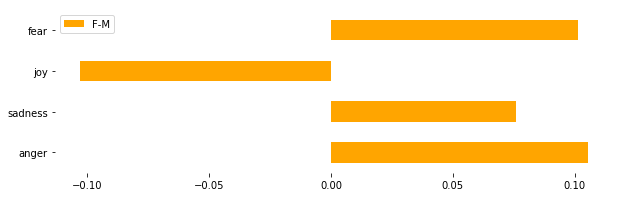

In [43]:
fig, ax = plt.subplots(figsize=(10,3), )
sns.despine(ax=ax, bottom=True, left=True)
gender_bias_df[gender_bias_df['Platform'] == 'AWS'][['Emotion','F-M']].plot(ax=ax, kind='barh', color=['orange', 'blue'], stacked=True)
ax.yaxis.set_ticklabels(['anger', 'sadness', 'joy', 'fear'])

[Text(0, 0, 'anger'),
 Text(0, 0, 'sadness'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'fear')]

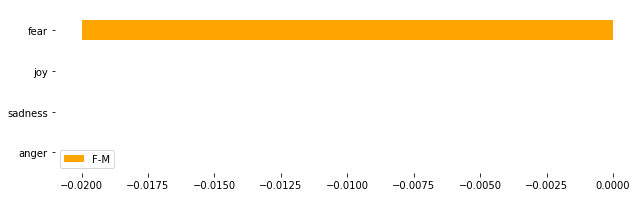

In [44]:
fig, ax = plt.subplots(figsize=(10,3), )
sns.despine(ax=ax, bottom=True, left=True)
gender_bias_df[gender_bias_df['Platform'] == 'Google'][['Emotion','F-M']].plot(ax=ax, kind='barh', color=['orange', 'blue'], stacked=True)
ax.yaxis.set_ticklabels(['anger', 'sadness', 'joy', 'fear'])

In [158]:
def create_racial_bias_df():
    """Calculate p-values for the racial pairings, and put in a uniform data frame."""
    deltas = []
    frames = []
    fig, axes = plt.subplots(1, len(_EMOTIONS), figsize=(18,4), sharey=True)
    merge_cols = ['Template', 'Emotion word', 'Emotion']
    aa_probs_df = emotion_df[_RACE_COLUMNS][emotion_df['Race'] == 'African-American']
    eu_probs_df = emotion_df[_RACE_COLUMNS][emotion_df['Race'] == 'European']
    race_probs_df = pds.merge(aa_probs_df, eu_probs_df, on=merge_cols, how='inner')
    race_probs_df_filtered = race_probs_df.drop_duplicates(subset=['ID_x'], inplace=False, keep='first').drop_duplicates(subset=['ID_y'], inplace=False, keep='first')
    for idx, emotion in enumerate(_EMOTIONS):
        ax = axes[idx]
        em = race_probs_df_filtered[(race_probs_df_filtered['Emotion'] == emotion)]
        print (len(em))
        display_df = pds.DataFrame(index=range(0, 2*len(em)), columns=['Race', 'Score', 'Emotion'])
        print(len(display_df))
        aa_scores = combine_aws_scores(em[em['Race_x'] == 'African-American'], 'x')
        display_df.loc[:len(aa_scores)-1, 'Score'] = aa_scores
        display_df.loc[:len(aa_scores)-1, 'Race'] =  'African-American'
        eu_scores = combine_aws_scores(em[em['Race_y'] == 'European'], 'y')
        display_df.loc[len(aa_scores):, 'Score'] = eu_scores
        display_df['Score'] = display_df['Score'].astype(float)
        display_df.loc[len(aa_scores):, 'Race'] =  'European'
        display_df.loc[:, 'Emotion'] = emotion
        frames.append(display_df)
        
        _, p = wilcoxon(aa_scores, eu_scores)
        print('AWS emotion: {}, p-value : {}'.format(emotion, p))
        y_max = np.max(np.concatenate((aa_scores, eu_scores)))
        y_min = np.min(np.concatenate((aa_scores, eu_scores)))
        sns.boxplot(data=display_df, x='Race', y='Score', ax=ax)
        print (y_max)
        ax.annotate("", xy=(0, y_max), xycoords='data',
                    xytext=(1, y_max), textcoords='data',
                    arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                                    connectionstyle="bar,fraction=0.2"))
        ax.text(0, y_max + .3, stars(p),
                horizontalalignment='left',
                verticalalignment='center')
        ax.set_xlabel(emotion, )
        if idx == 0:
            ax.set_ylabel('Score', rotation=0,)
        else:
             ax.set_ylabel('', rotation=0,)
        delta = (aa_scores - eu_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'AWS', 'p-value': p, 'Disparity': 'Black/White', 'delta': delta})
        aa_scores = em[em['Race_x'] == 'African-American']['goog_scores_x']
        eu_scores = em[em['Race_y'] == 'European']['goog_scores_y']
        _, p = wilcoxon(aa_scores, eu_scores)
        print('Google emotion: {}, p-value : {}'.format(emotion, p))
        delta = 0 if p > 0.05 else (aa_scores - eu_scores).mean()
        deltas.append({'Emotion': emotion, 'Platform': 'Google', 'p-value': p, 'Disparity': 'Black/White', 'delta': delta})
    
    combined_data = pds.concat(frames, ignore_index=True)
    combined_data['Score'] = combined_data['Score'].astype(float)
    #sns.boxplot(data=combined_data, x='Emotion', y='Score', hue='Race')
    #sns.swarmplot(data=combined_data, x='Emotion', y='Score', hue='Race')
    return combined_data, pds.DataFrame.from_dict(deltas)

In [144]:
def stars(p):
    if (p < 0.05):
        return "p < 0.05 !"
    else:
        return "No significant difference"

35
70
AWS emotion: anger, p-value : 2.703123552440088e-07
-0.006394091993570335
Google emotion: anger, p-value : 7.957971565233185e-06
35
70
AWS emotion: sadness, p-value : 6.660326758646149e-06
0.261255856603384
Google emotion: sadness, p-value : 3.787249253316128e-06
35
70
AWS emotion: joy, p-value : 2.4770276393652366e-07
0.9861858364311046
Google emotion: joy, p-value : 0.0003390212969694532
35
70
AWS emotion: fear, p-value : 3.2924713208836836e-06
0.3010863810777664
Google emotion: fear, p-value : 0.026943676888349928


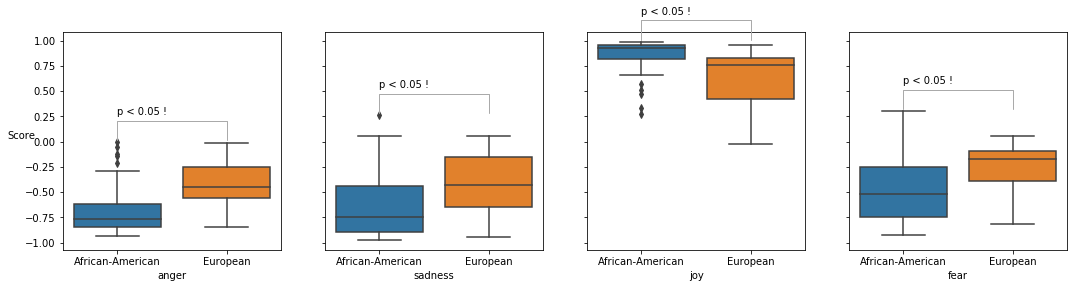

In [159]:
combined_data, racial_bias_uniform_df = create_racial_bias_df()

In [89]:
len(combined_data[(combined_data['Race'] == 'European' ) & (combined_data['Emotion'] == 'anger' )])

35

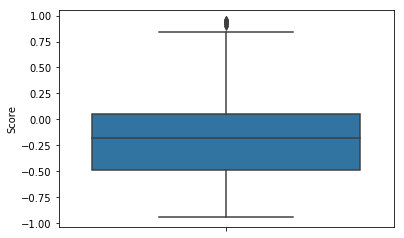

In [107]:
sns.boxplot(data=combined_data[combined_data['Race'] == 'European'], y='Score', )

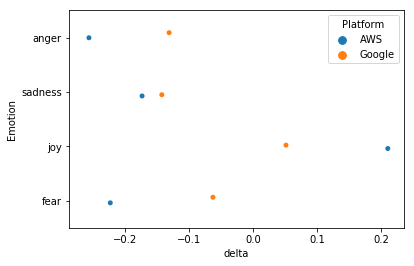

In [56]:
sns.stripplot(data=racial_bias_uniform_df[['Emotion','delta', 'Platform']], y="Emotion", x="delta", hue='Platform', )

In [ ]:
emotion_aws = racial_bias_uniform_df[racial_bias_uniform_df['Emotion'] ]

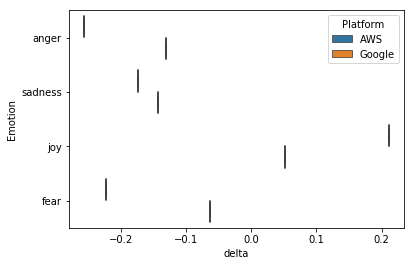

In [61]:
sns.boxplot(data=racial_bias_uniform_df[['Emotion','delta', 'Platform']], y="Emotion", x="delta", hue='Platform', )

In [64]:
columns = ['gender','emotion', 'score']
test_df = pds.DataFrame(index=range(0,10), columns=columns)

In [68]:
test_df.loc[0:5,'gender'] = 'FeMale'

In [69]:
test_df

,gender,emotion,score
0,FeMale,NaN,NaN
1,FeMale,NaN,NaN
2,FeMale,NaN,NaN
3,FeMale,NaN,NaN
4,FeMale,NaN,NaN
5,FeMale,NaN,NaN
6,Male,NaN,NaN
7,Male,NaN,NaN
8,Male,NaN,NaN
9,Male,NaN,NaN
